In [1]:
import sys, os
sys.path.insert(0, 'D:\Senior Year Northeastern University\DS Capstone\ImageOutpainting')
#print(sys.path)

import random
random.seed(0)

import numpy as np
import torch
from PIL import ImageColor, Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import importlib
rootdir = "../../ImageOutpainting"

config = importlib.import_module("model.config", rootdir)
u = importlib.import_module("model.common.util", rootdir)
config = config.Config()
utils = u.Util(config)

trainer = importlib.import_module("model.Pix2Pix.trainer", rootdir)
mask_transforms = importlib.import_module("model.common.mask_transforms", rootdir)
mask_gen = importlib.import_module("model.common.mask_gen")


In [2]:
gen = trainer.Trainer(config, utils).get_generator()

In [9]:
def shift_image_4(img):
    print(4)
    if not config.recur_bool:
        return img
    elif config.recur_direction == "top":
        img[:,
            :,
            config.stripe_width:,
            :] = img[:,:,:config.pic_width-config.stripe_width,:]
        return img
    elif config.recur_direction == "bottom":
        img[:,
            :,
            :config.pic_height-config.stripe_width,
            :] = img[:,:,config.stripe_width:,:]
        return img
    elif config.recur_direction == "left":
        img[:,
            :,
            :,
            config.stripe_width:] = img[:,:,:,:config.pic_width-config.stripe_width]
        return img
    elif config.recur_direction == "right":
        img[:,
            :,
            :,
            :config.pic_width-config.stripe_width] = img[:,:,:,config.stripe_width:]
        return img
    else:
        raise ValueError(f"Cannot shift image in direction {self.config.recur_direction}")
   
def shift_image_3(img):
    print(3)
    if not config.recur_bool:
        return img
    elif config.recur_direction == "top":
        img[:,
            config.stripe_width*21:,
            :] = img[:,
                     :config.pic_height-21*config.stripe_width,
                     :]
        u.show(img)
        raise ValueError("here")
        return img
    elif config.recur_direction == "bottom":
        img[:,
            :config.pic_height-config.stripe_width,
            :] = img[:,config.stripe_width:,:]
        return img
    elif config.recur_direction == "left":
        img[:,
            :,
            config.stripe_width:] = img[:,:,:config.pic_width-config.stripe_width]
        return img
    elif config.recur_direction == "right":
        img[:,
            :,
            :config.pic_width-config.stripe_width] = img[:,:,config.stripe_width:]
        return img
    else:
        raise ValueError(f"Cannot shift image in direction {self.config.recur_direction}")

def shift_image(img):
    if len(img.shape) == 4:
        return shift_image_4(img)
    elif len(img.shape) == 3:
        return shift_image_3(img)
    else:
        raise ValueError(f"Dimensions = {len(img.shape)}")
    
def average_images_help(t1, t2, proportion=0.5):
    return t1*proportion+t2*(1-proportion)
        
def average_images(generated, base_truth, proportion_generated = 0.5):
    print("average_images")
    if not config.recur_bool:
        return generated
    
    indexing = None
    if config.recur_direction == "top":
        x, y = generated[:, :, config.stripe_width:, :], base_truth[:, :3, config.stripe_width:, :]
        generated[:, :, config.stripe_width:, :] = average_images_help(x, y, proportion_generated)
    
    elif config.recur_direction == "bottom":
        x, y = generated[:, :, :config.pic_height-config.stripe_width, :], base_truth[:, :3, :config.pic_height-config.stripe_width, :]
        generated[:, :, :config.pic_height-config.stripe_width, :] = average_images_help(x, y, proportion_generated)
    
    elif config.recur_direction == "left":
        x, y = generated[:, :, :, config.stripe_width:], base_truth[:, :3, :, config.stripe_width:]
        generated[:, :, :, config.stripe_width:] = average_images_help(x, y, proportion_generated)
    
    elif config.recur_direction == "right":
        x, y = generated[:, :, :, :config.pic_width-config.stripe_width], base_truth[:, :3, :, :config.pic_width-config.stripe_width]
        generated[:, :, :, :config.pic_width-config.stripe_width] = average_images_help(x, y, proportion_generated)
    
    elif config.recur_direction not in ["top", "bottom", "right", "left"]:
        raise ValueError(f"Cannot averages image with direction {self.config.recur_direction}")
    
    return generated
    

In [10]:
class Utils:
    def show(self, img):
        print("dim of shown pic:", img.shape)
        toPIL = transforms.ToPILImage()
        if len(img.shape) == 4:
            img = toPIL(img[:, :3, :, :][0])
        else:
            img = toPIL(img)
        plt.imshow(img)
u = Utils()

In [11]:
class ImageLoader:
    def __init__(self, filepaths):
        self.filepaths = filepaths
    
    def __iter__(self):
        for fp in self.filepaths:
            to_yield = Image.open(fp), None
            yield to_yield

In [12]:
d = f"{rootdir}\\model\\dataset\\places365_standard\\train\\boardwalk"
#d = "D:\Senior Year Northeastern University\DS Capstone\ImageOutpainting\model\dataset\outside_data\Selected Options\Bottom"
d = f"{rootdir}\\model\\dataset\\places365_standard\\train\\arcade"
#d = "D:\Senior Year Northeastern University\DS Capstone\ImageOutpainting\model\dataset\outside_data\Selected Options\Monochrome"

class RecurDataset(torch.utils.data.IterableDataset):
    
    def __init__(self, shuffle=False):
        super(RecurDataset).__init__()
        self.dataset = self.load_dataset()
        self.shuffle = shuffle
                
    def __iter__(self):
        for x, _ in iter(self.dataset):
            both = transforms.Compose([
                transforms.Resize((config.pic_height, config.pic_width)),
                transforms.ToTensor(),
                mask_transforms.RandomRightTransform(config, right_chance = 1.1)
            ])

            xonly = ApplyMaskTransform(config, extra_dim=(not config.should_collapse))
            yonly = MaskedAreaTransform(config)
            p = both(x)
            yield xonly(p), yonly(p)
            
    def __len__(self):
        return len(self.train_dataset)
    
    def get_pic_filepaths(self):
        for pic in os.listdir(d):
            yield os.path.join(d, pic)
                
    def load_dataset(self):
        filepaths = list(self.get_pic_filepaths())
        return ImageLoader(filepaths)

In [13]:
recur_loader = RecurDataset(shuffle=True).dataset

3
dim of shown pic: torch.Size([3, 256, 256])


ValueError: here

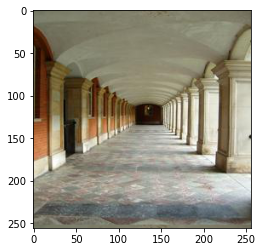

In [14]:
both = transforms.Compose([
                transforms.Resize((config.pic_height, config.pic_width)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                shift_image,
                mask_transforms.RandomBorderMaskTransform(config)
            ])
xonly = mask_transforms.ApplyMaskTransform(config, extra_dim=(not config.should_collapse))
yonly = mask_transforms.MaskedAreaTransform(config)

for i, (X, y) in enumerate(recur_loader):
    p = both(X)
    x_, y_ = xonly(p), yonly(p)
    x_, y_ = torch.reshape(x_, (1, x_.shape[0], x_.shape[1], x_.shape[2])), torch.reshape(y_, (1, y_.shape[0], y_.shape[1], y_.shape[2]))
    x_ = x_.to(torch.device('cuda'))
    mask = x_[:,3:,:,:]
    u.show(x_)
    raise ValueError()
    
    n_recursions = 1
    for _ in range(n_recursions):
        if _ != 0:
            x_ = torch.cat((x_, mask), dim=1)
            x_ = shift_image(x_)
        generated_x_ = gen(x_)
        x_ = average_images(generated_x_, x_, proportion_generated = 0.0)
    if i > -1:
        break
    
u.show(x_)
print(x_.shape)

In [15]:
from torch import Tensor
x = Tensor([[1,1],[1,1]])
y = Tensor([[3,2],[2,2]])
torch.add(x*0.5, y*0.5)

tensor([[2.0000, 1.5000],
        [1.5000, 1.5000]])